In [31]:
using Revise

In [32]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

In [33]:
using Blink

In [34]:
robot = CartPole(add_contacts=false)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 3921`, ProcessRunning), TCPSocket(RawFD(71) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(4, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(76) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 4, Nullable{Any}(true))))

In [35]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params)
net, loss = LearningMPC.mimic_net([4, 16, 16, 16, 1]; regularization=0.0)
optimizer = Flux.ADAM(Flux.params(net); decay=1e-6)

net_controller = let net = net
    function (τ, t, x)
        τ .= Flux.Tracker.data(net(LearningMPC.qv(x)))
    end
end

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_controller]);

Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [36]:
sample_sink = LearningMPC.MPCSampleSink(keep_nulls=false; lqrsol=lqrsol, 
    lqr_warmstart_index=1,
    learned_warmstart_index=2)

playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.multiplex!(
    sample_sink,
    playback_sink
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.multiplex!(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_controller),
    live_viewer
    )

collect_into! = let x_init = nominal_state(robot), x0 = MechanismState{Float64}(robot.mechanism), sink = sample_sink
    function (data::Vector{<:LearningMPC.Sample}, σv)
        empty!(sink)
        LearningMPC.randomize!(x0, x_init, 0.5, σv)
        results = LCPSim.simulate(x0, 
            dagger_controller,
            robot.environment, params.Δt, 100, 
            params.lcp_solver;
            termination=x -> !(-π/4 <= configuration(x)[2] <= π/4))
        append!(data, sink.samples)
    end
end

(::#77) (generic function with 1 method)

In [37]:
library_file = "library-3.jld2"
dataset_file = "cartpole-mimic-3.jld2"

"cartpole-mimic-3.jld2"

In [38]:
if isfile(library_file)
    all_training_data, all_validation_data = jldopen(library_file) do file
        file["training"], file["testing"]
    end
else
    all_training_data = Vector{Tuple{eltype(sample_sink.samples)}}()
    all_validation_data = Vector{Tuple{eltype(sample_sink.samples)}}()
end;

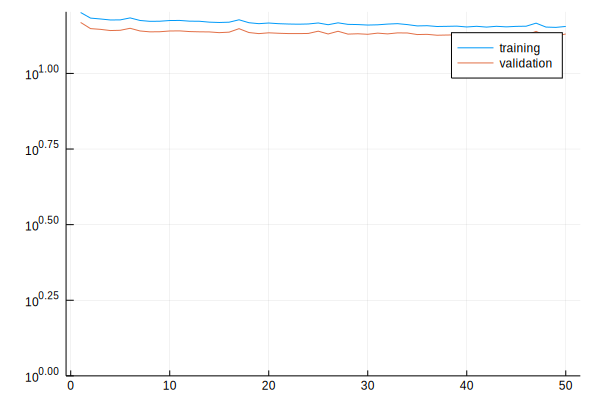

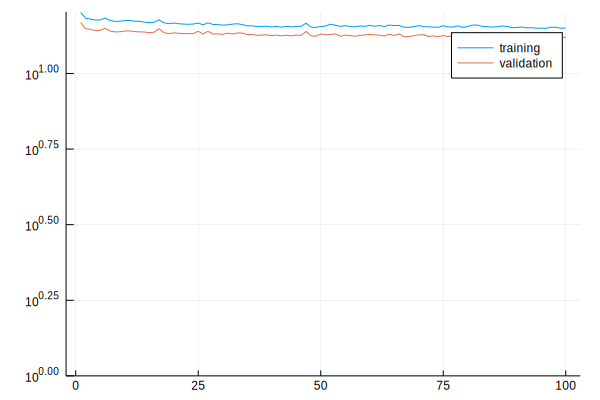

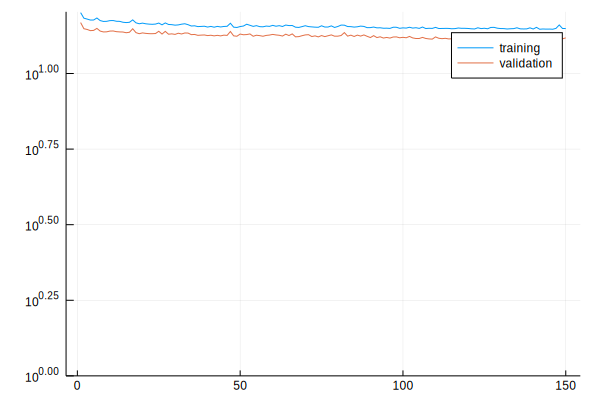

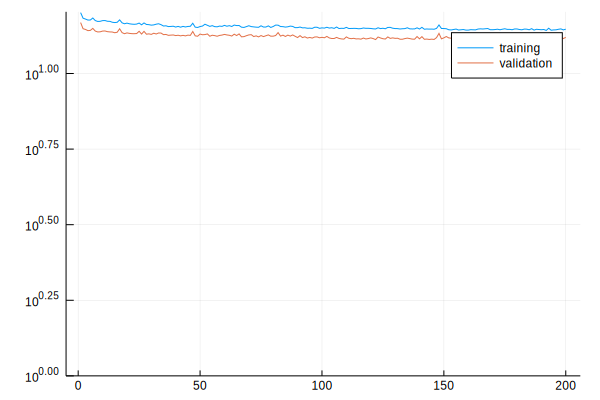

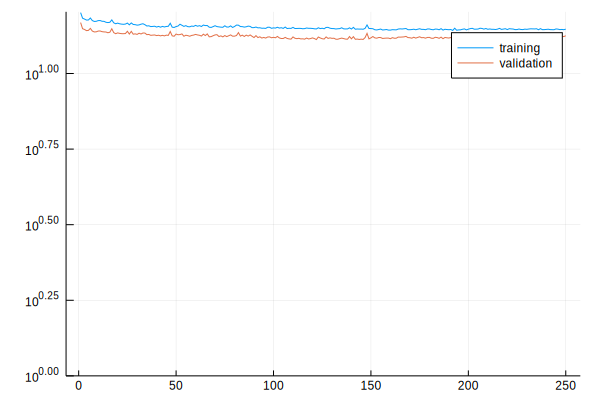

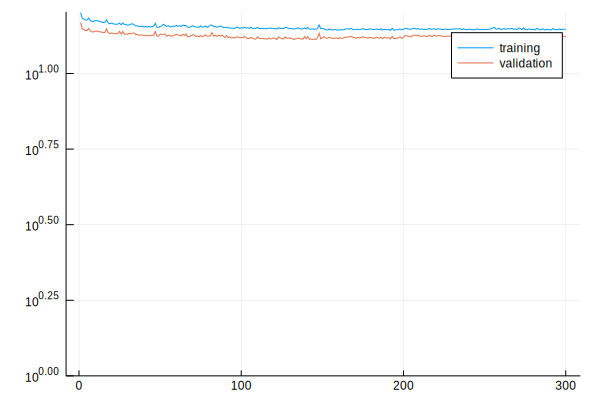

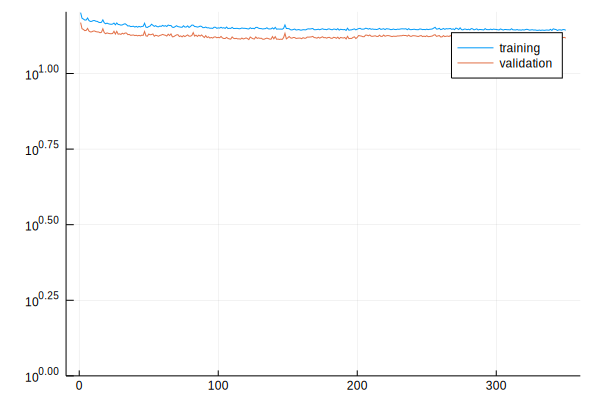

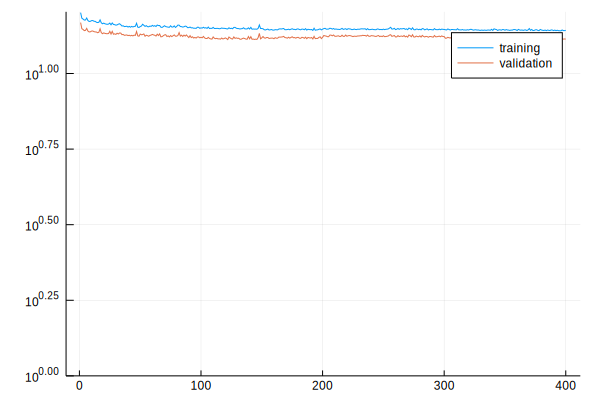

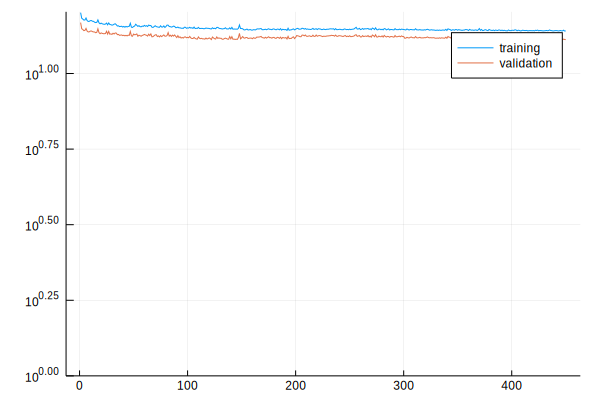

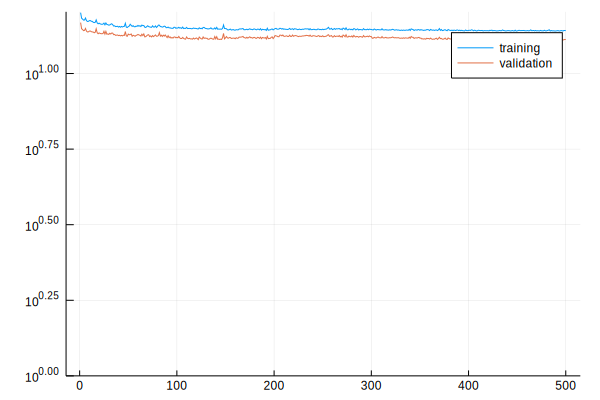

917.044445 seconds (2.72 G allocations: 156.793 GiB, 9.49% gc time)
944.094761 seconds (2.75 G allocations: 158.641 GiB, 9.49% gc time)
970.809091 seconds (2.81 G allocations: 162.077 GiB, 9.65% gc time)
967.356424 seconds (2.84 G allocations: 163.815 GiB, 9.45% gc time)
958.293119 seconds (2.88 G allocations: 165.830 GiB, 9.71% gc time)
955.900345 seconds (2.91 G allocations: 167.568 GiB, 9.83% gc time)
964.620279 seconds (2.94 G allocations: 169.306 GiB, 9.60% gc time)
982.211946 seconds (3.00 G allocations: 172.743 GiB, 9.74% gc time)
996.530939 seconds (3.03 G allocations: 174.547 GiB, 9.85% gc time)
1002.782086 seconds (3.09 G allocations: 177.983 GiB, 8.89% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 2:56:00


In [39]:
function mirror(s::S) where {S <: LearningMPC.Sample}
    S(-1 .* s.state,
      -1 .* s.input,
      s.x0,
      s.u0,
      s.warmstart_costs,
      s.mip)
end

datasets = Vector{LearningMPC.Dataset{Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 10
σv = 5.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    for i in 1:2
        collect_into!(dataset.training_data, σv)
    end
    
    filter!(dataset.training_data) do sample
        all(isfinite, sample.input)
    end
    

    
    new_samples = tuple.(dataset.training_data)
    if !isempty(new_samples)
        new_training, new_validation = splitobs(shuffleobs(new_samples); at=0.8)
        append!(all_training_data, new_training)
        append!(all_validation_data, new_validation)
        
        # The cart-pole system is symmetric, so for every sample with state x and input u,
        # we can sythesize an example with state -x and input -u with the same cost bounds
        append!(all_training_data, tuple.(mirror.(first.(new_training))))
        
        # The cart-pole system is symmetric, so for every sample with state x and input u,
        # we can sythesize an example with state -x and input -u with the same cost bounds
        append!(all_validation_data, tuple.(mirror.(first.(new_validation))))
    end

    @time for i in 1:50
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen(dataset_file, "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt, 
            "horizon" => params.horizon,
        )
        file["losses"] = losses
    end
    
#     jldopen(library_file, "w") do file
#         file["training"] = all_training_data
#         file["testing"] = all_validation_data
#     end
    
    plt = plot(first.(losses), label="training", yscale=:log10)
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (1, ylims(plt)[2]))
    display(plt)

end